# Evaluate new polynomial solution

In [1]:
import funcs
from distortionMaps import d2cMapping

import numpy as np
from datetime import date
from astropy.io import fits
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
# directories

# USER:
user = "yannis" # "alvaro","yannis"
# Set work directory
if user == "alvaro":
    workDir = "./"
if user == "yannis":
    workDir  = "/Users/ioannisa/Desktop/python/miri_devel/"

datadir = "data/"
cdpDir = workDir+"cdp_data/"

# analysis inputs
band = "2B"
etal = "ET1A" # "ET1A", "ET1B"
islice = 8

# load new wavelength solution
wavsolution_file   = 'data/Band'+str(band)+'_ET'+ etal[-2:] +'_slice'+str(islice)+'_coeffs.txt'
slice_wavcoeffs = np.loadtxt(wavsolution_file,unpack=True, skiprows = 5)

In [3]:
# load distortion maps
d2cMaps   = d2cMapping(band,cdpDir)
sliceMap  = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

# compute slice reference x-position
alpha_img = np.zeros(det_dims)
alpha_img[(sliceMap == 100*int(band[0])+islice)] = alphaMap[(sliceMap == 100*int(band[0])+islice)]
x_coords = np.nonzero(alpha_img[512,:])[0]
alphas = alpha_img[512,:][x_coords]
x_s = interp1d(alphas,x_coords)(0.)

In [4]:
fileversion = "06.04.00"
distcdp = {}
distcdp["3C"] = "MIRI_FM_MIRIFULONG_34LONG_DISTORTION_%s.fits" %fileversion
distcdp["3B"] = "MIRI_FM_MIRIFULONG_34MEDIUM_DISTORTION_%s.fits" %fileversion
distcdp["3A"] = "MIRI_FM_MIRIFULONG_34SHORT_DISTORTION_%s.fits" %fileversion

distcdp["1C"] = "MIRI_FM_MIRIFUSHORT_12LONG_DISTORTION_%s.fits" %fileversion
distcdp["1B"] = "MIRI_FM_MIRIFUSHORT_12MEDIUM_DISTORTION_%s.fits" %fileversion
distcdp["1A"] = "MIRI_FM_MIRIFUSHORT_12SHORT_DISTORTION_%s.fits" %fileversion

distcdp["4C"] = distcdp["3C"]
distcdp["4B"] = distcdp["3B"]
distcdp["4A"] = distcdp["3A"]

distcdp["2C"] = distcdp["1C"]
distcdp["2B"] = distcdp["1B"]
distcdp["2A"] = distcdp["1A"]

In [5]:
band2B_distCDP = fits.open(cdpDir+distcdp["2B"])
slice_wavcoeffs_cdp = np.array(band2B_distCDP['Lambda_CH1'].data[islice-1])

In [6]:
print '------DISTORTION CDP version {}--------'.format(fileversion)
print 'Reference x-position: {}pix'.format(round(slice_wavcoeffs_cdp[0],2))
print '2D polynomial coefficients: {}'.format(slice_wavcoeffs_cdp[1:])
print ''
print '------NEW WAVECAL--------'
print 'Reference x-position: {}pix'.format(round(x_s,2))
print '2D polynomial coefficients: {}'.format(slice_wavcoeffs)

------DISTORTION CDP version 06.04.00--------
Reference x-position: 169.78pix
2D polynomial coefficients: [  5.64439479e+00  -1.13157156e-05   5.56199104e-08  -2.00449112e-09
  -2.13968992e-12   1.12452035e-03   1.05521179e-07   4.18413488e-10
   6.00691118e-12  -1.45918406e-12  -1.36283817e-07  -2.63230311e-11
  -1.01821561e-12  -1.39653875e-14   8.78117901e-15   2.05591128e-11
   1.69008630e-14   1.38596553e-15   4.21708145e-18  -1.44578247e-17
  -5.07246636e-15  -7.64261887e-18  -6.93733655e-19   4.44398265e-21
   7.12065038e-21]

------NEW WAVECAL--------
Reference x-position: 936.54pix
2D polynomial coefficients: [  8.66884248e+00   5.35320080e-03   1.37751611e-04   0.00000000e+00
   0.00000000e+00   1.55748204e-03  -1.29336256e-05   3.51435770e-08
   0.00000000e+00   0.00000000e+00  -5.47993448e-09   1.28343589e-08
  -1.48359735e-11   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.0000000

In [12]:
channel = int(band[0])
new_lambdaMap  = np.zeros(sliceMap.shape)

for islice in range(1,nslices+1):
    # load new wavelength solution
    wavsolution_file   = 'data/Band'+str(band)+'_ET'+ etal[-2:] +'_slice'+str(islice)+'_coeffs.txt'
    slice_wavcoeffs = np.loadtxt(wavsolution_file,unpack=True,skiprows = 5)
    
    # create placeholder and identify pixels in slice
    pixelCtry,pixelCtrx = np.where(sliceMap == int(islice+100*channel))
    lambdas   = np.zeros(len(pixelCtry))
    
    # apply the 2D polynomial transform
    lp = slice_wavcoeffs
    # compute slice reference x-position
    alpha_img = np.zeros(det_dims)
    alpha_img[(sliceMap == 100*int(band[0])+islice)] = alphaMap[(sliceMap == 100*int(band[0])+islice)]
    x_coords = np.nonzero(alpha_img[512,:])[0]
    alphas = alpha_img[512,:][x_coords]
    xs = interp1d(alphas,x_coords)(0.)
    for i in range(5):
        for j in range(5):
            cIndex = i*5 + j
            lambdas   = lambdas + lp[cIndex]*(pixelCtrx-xs)**j * pixelCtry**i
    new_lambdaMap[pixelCtry,pixelCtrx]   = lambdas

<IPython.core.display.Javascript object>


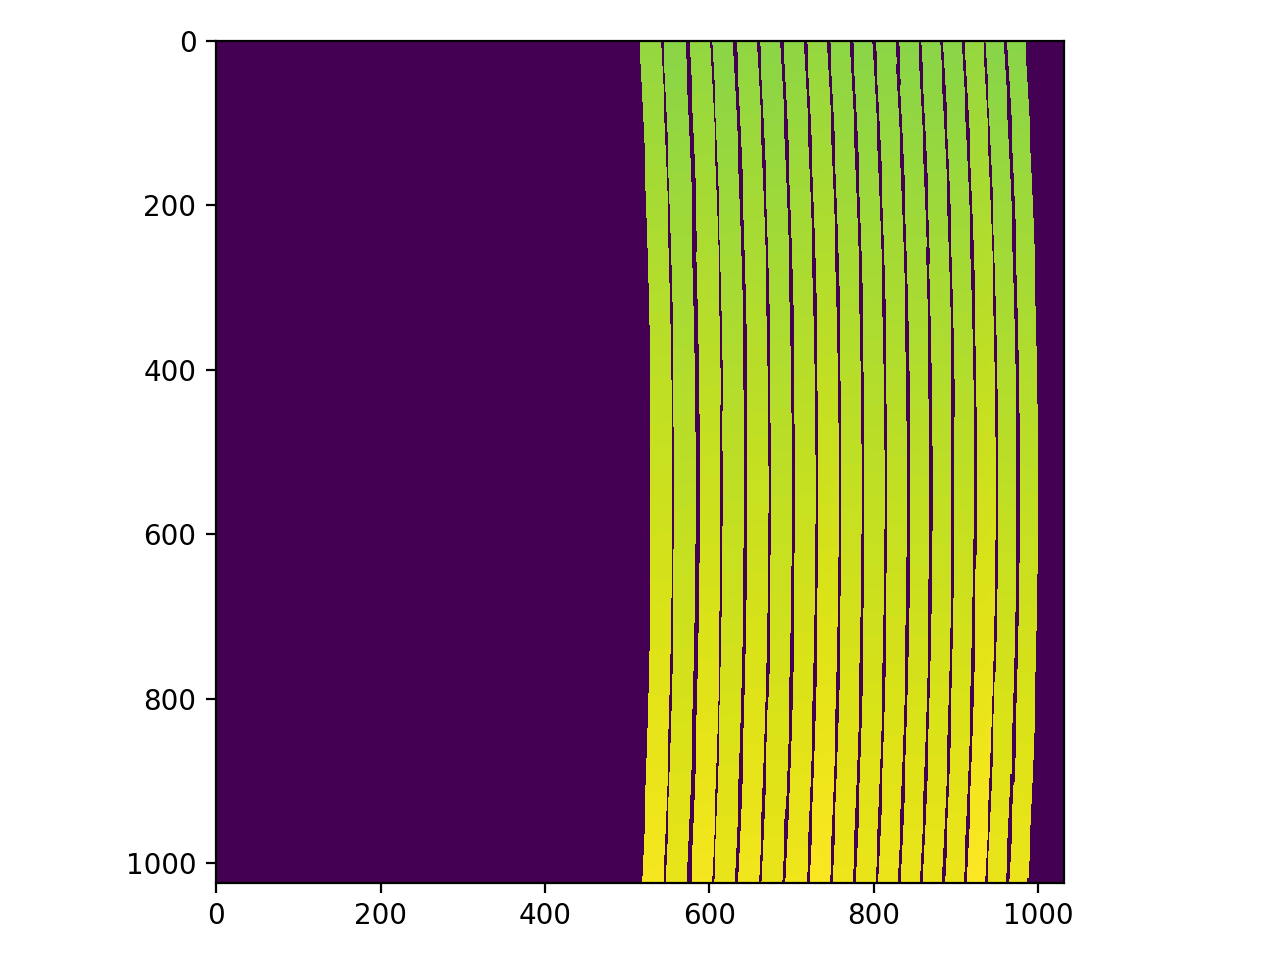

<IPython.core.display.Javascript object>


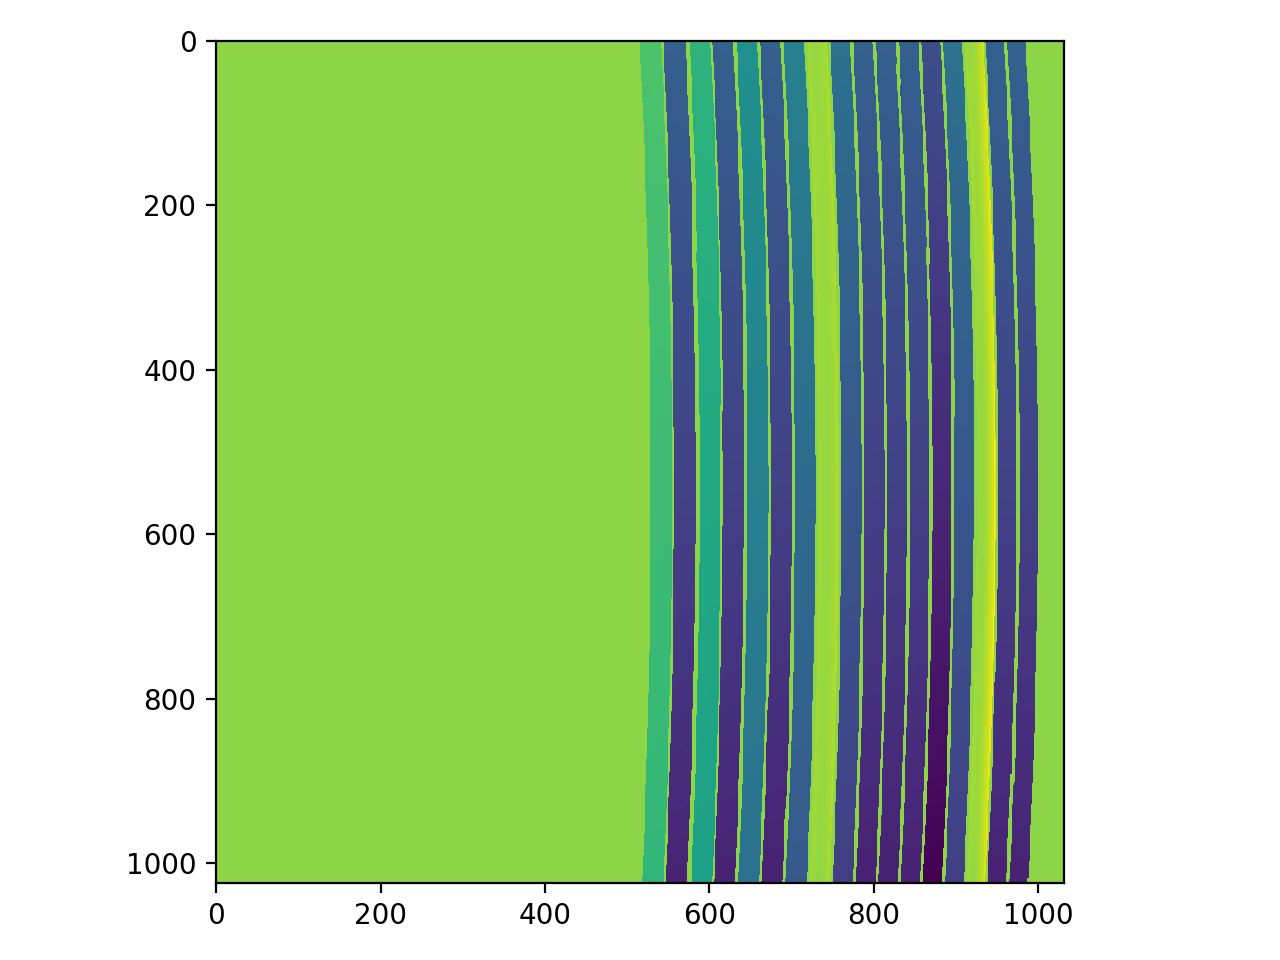

In [13]:
plt.figure()
plt.imshow(new_lambdaMap)
plt.tight_layout()

plt.figure()
plt.imshow(new_lambdaMap-lambdaMap)
plt.tight_layout()